# 3D Convolution Classification
As a potential method of approaching the misalignment problem, understanding how 3D convolutions work and their computational caveats is important. This notebook goes through the creation and analysis of a 3D convolutional neural network classifying 3D MNIST data.
## Setup
Importing essential packages and loading training data, analyzing the shape and datatype of the inputs.

In [31]:
# Default packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Neural net and optimizer packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Other
import h5py
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 

In [9]:
# Load training data
path_dir = "/home/liam/Data/"
with h5py.File(path_dir + "full_dataset_vectors.h5", "r") as data:
    X_train = data["X_train"][:]    
    y_train = data["y_train"][:]   
    X_test = data["X_test"][:]     
    y_test = data["y_test"][:]
    
# Observe shape and datatypes of input data
    print('X_train   :   shape:', X_train.shape, '         type:', type(X_train))
    print('y_train   :   shape:', y_train.shape, '              type:', type(y_train))
    print('X_test    :   shape:', X_test.shape, '          type:', type(X_test))
    print('y_test    :   shape:', y_test.shape, '               type:', type(y_test))

X_train   :   shape: (10000, 4096)          type: <class 'numpy.ndarray'>
y_train   :   shape: (10000,)               type: <class 'numpy.ndarray'>
X_test    :   shape: (2000, 4096)           type: <class 'numpy.ndarray'>
y_test    :   shape: (2000,)                type: <class 'numpy.ndarray'>


## Preparing Data
Now the images must be transformed to fit the 16 by 16 by 16 MNIST images. Also, one-hot encoding must be done to the training labels for the data as well in order to process them in a neural network model.

In [10]:
# Resize image vectors to fit 16x16x16 MNIST images
def transform_images_dataset(data):
    th, upper, lower = 0.2, 1, 0
    data = np.where(data > th, upper, lower)
    data = data.reshape(data.shape[0], 1, 16, 16, 16)
    data = np.stack((data,) * 3, axis = -1)
    return(torch.as_tensor(data))

X_train = transform_images_dataset(X_train)
X_test = transform_images_dataset(X_test)

In [11]:
# Create one_hot encodings of labels
def one_hot_data(target):
    target_tensor = torch.as_tensor(target)
    one_hot = F.one_hot(target_tensor, num_classes = 10)
    return(one_hot)

y_train = one_hot_data(y_train)
y_test = one_hot_data(y_test)

In [12]:
# Observe modified shapes and datatypes of data
print('X_train   :   shape:', X_train.shape, '          type:', type(X_train))
print('y_train   :   shape:', y_train.shape, '                     type:', type(y_train))
print('X_test    :   shape:', X_test.shape, '           type:', type(X_test))
print('y_test    :   shape:', y_test.shape, '                      type:', type(y_test))

X_train   :   shape: torch.Size([10000, 1, 16, 16, 16, 3])           type: <class 'torch.Tensor'>
y_train   :   shape: torch.Size([10000, 10])                      type: <class 'torch.Tensor'>
X_test    :   shape: torch.Size([2000, 1, 16, 16, 16, 3])            type: <class 'torch.Tensor'>
y_test    :   shape: torch.Size([2000, 10])                       type: <class 'torch.Tensor'>


## Model Preparation
Now the model will be created with two convolution layers with 3 by 3 by 3 kernels. There will also be 2 by 2 by 2 max-pooling. The data is loaded, loss function created, and optimizer set.

In [14]:
# Create 3d CNN for classification
class CNN_classification_model(nn.Module):
    def __init__(self):
        super(CNN_classification_model, self).__init__()
        self.model= nn.Sequential(
        
        #Conv layer 1    
        nn.Conv3d(3, 32, kernel_size=(3, 3, 3), padding=0),
        nn.ReLU(),
        nn.MaxPool3d((2, 2, 2)),   
        
        #Conv layer 2  
        nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=0),
        nn.ReLU(),
        nn.MaxPool3d((2, 2, 2)),
               
        #Flatten
        nn.Flatten(),  
        #Linear 1
        nn.Linear(2**3*64, 128), 
        #Relu
        nn.ReLU(),
        #BatchNorm1d
        nn.BatchNorm1d(128),
        #Dropout
        nn.Dropout(p=0.15),
        #Linear 2
        nn.Linear(128, num_classes)
        )
    

    def forward(self, x):
        # Set 1
        out = self.model(x)
        return out
    
# Accuracy function
def accuracyFUNCTION (predicted, targets):          
    c=0
    for i in range(len(targets)):
        if (predicted[i] == targets[i]):
            c+=1
    accuracy =  c / float(len(targets))
    print('accuracy   = ', c ,'/', len(targets))
    return(accuracy)

In [22]:
batch_size = 100    

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train.float(),y_train.long())
test = torch.utils.data.TensorDataset(X_test.float(),y_test.long())

# data loader with pytorch
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

# we have 10 classes
num_classes = 10

# The number of epochs
num_epochs = 50

# 3D model
model = CNN_classification_model()

#You can use the GPU by typing: model.cuda()
print(model)

# Loss function : Cross Entropy
error = nn.CrossEntropyLoss()

# Learning rate : learning_r = 0.01
learning_r = 0.01

# SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_r)

CNN_classification_model(
  (model): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=512, out_features=128, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.15, inplace=False)
    (11): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Model Training
The model will now be trained, with data being printed indicating the accuracy of the model and the loss as it iterates over the data.

In [24]:
# Train model, printed statistics
itr = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        train = Variable(images.view(100,3,16,16,16))
        labels = Variable(labels)
        
        #  zero_grad : Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation / CNN_classification_model
        outputs = model(train)
        
        # Calculate loss value / using cross entropy function 
        labels= labels.argmax(-1)
        loss = error(outputs, labels)
        loss.backward()
        
        # Update parameters using SGD optimizer 
        optimizer.step()
        
        #calculate the accuracy using test data
        itr += 1
        if itr % 50 == 0:
            # Prepare a list of correct results and a list of anticipated results.     
            listLabels=[]
            listpredicted=[]
            # test_loader
            for images, labels in test_loader:

                test = Variable(images.view(100,3,16,16,16))
                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # used to convert the output to binary variables
                predicted= one_hot_data (predicted) 
                # Create a list of predicted data
                predlist=[]
                for i in range(len(predicted)):
                    p = int(torch.argmax(predicted[i]))
                    predlist.append(p)

                
                listLabels+=(labels.argmax(-1).tolist())
                listpredicted+=(predlist)

                
                # calculate Accuracy
            accuracy= accuracyFUNCTION(listpredicted, listLabels)
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(itr, loss.data, accuracy))

            # store loss and accuracy. They'll be required to print the curve.
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)

0it [00:00, ?it/s]

accuracy   =  780 / 2000
Iteration: 50  Loss: 1.862661600112915  Accuracy: 0.39 %
accuracy   =  894 / 2000
Iteration: 100  Loss: 1.5384228229522705  Accuracy: 0.447 %


0it [00:00, ?it/s]

accuracy   =  939 / 2000
Iteration: 150  Loss: 1.5384166240692139  Accuracy: 0.4695 %
accuracy   =  998 / 2000
Iteration: 200  Loss: 1.3449658155441284  Accuracy: 0.499 %


0it [00:00, ?it/s]

accuracy   =  1038 / 2000
Iteration: 250  Loss: 1.3737872838974  Accuracy: 0.519 %
accuracy   =  1053 / 2000
Iteration: 300  Loss: 1.2483551502227783  Accuracy: 0.5265 %


0it [00:00, ?it/s]

accuracy   =  1087 / 2000
Iteration: 350  Loss: 1.2682045698165894  Accuracy: 0.5435 %
accuracy   =  1088 / 2000
Iteration: 400  Loss: 1.216404676437378  Accuracy: 0.544 %


0it [00:00, ?it/s]

accuracy   =  1096 / 2000
Iteration: 450  Loss: 1.1804225444793701  Accuracy: 0.548 %
accuracy   =  1132 / 2000
Iteration: 500  Loss: 1.118262529373169  Accuracy: 0.566 %


0it [00:00, ?it/s]

accuracy   =  1116 / 2000
Iteration: 550  Loss: 1.0512291193008423  Accuracy: 0.558 %
accuracy   =  1131 / 2000
Iteration: 600  Loss: 1.0782321691513062  Accuracy: 0.5655 %


0it [00:00, ?it/s]

accuracy   =  1141 / 2000
Iteration: 650  Loss: 1.0207139253616333  Accuracy: 0.5705 %
accuracy   =  1150 / 2000
Iteration: 700  Loss: 0.9749096632003784  Accuracy: 0.575 %


0it [00:00, ?it/s]

accuracy   =  1125 / 2000
Iteration: 750  Loss: 0.8898363709449768  Accuracy: 0.5625 %
accuracy   =  1137 / 2000
Iteration: 800  Loss: 0.9650714993476868  Accuracy: 0.5685 %


0it [00:00, ?it/s]

accuracy   =  1165 / 2000
Iteration: 850  Loss: 0.854506254196167  Accuracy: 0.5825 %
accuracy   =  1158 / 2000
Iteration: 900  Loss: 0.8321473598480225  Accuracy: 0.579 %


0it [00:00, ?it/s]

accuracy   =  1154 / 2000
Iteration: 950  Loss: 0.8062939643859863  Accuracy: 0.577 %
accuracy   =  1155 / 2000
Iteration: 1000  Loss: 0.7825453877449036  Accuracy: 0.5775 %


0it [00:00, ?it/s]

accuracy   =  1143 / 2000
Iteration: 1050  Loss: 0.7492106556892395  Accuracy: 0.5715 %
accuracy   =  1151 / 2000
Iteration: 1100  Loss: 0.6760255694389343  Accuracy: 0.5755 %


0it [00:00, ?it/s]

accuracy   =  1159 / 2000
Iteration: 1150  Loss: 0.7626271843910217  Accuracy: 0.5795 %
accuracy   =  1168 / 2000
Iteration: 1200  Loss: 0.6461368799209595  Accuracy: 0.584 %


0it [00:00, ?it/s]

accuracy   =  1137 / 2000
Iteration: 1250  Loss: 0.6256114840507507  Accuracy: 0.5685 %
accuracy   =  1152 / 2000
Iteration: 1300  Loss: 0.5259596705436707  Accuracy: 0.576 %


0it [00:00, ?it/s]

accuracy   =  1128 / 2000
Iteration: 1350  Loss: 0.5351804494857788  Accuracy: 0.564 %
accuracy   =  1156 / 2000
Iteration: 1400  Loss: 0.45979952812194824  Accuracy: 0.578 %


0it [00:00, ?it/s]

accuracy   =  1143 / 2000
Iteration: 1450  Loss: 0.5069659948348999  Accuracy: 0.5715 %
accuracy   =  1155 / 2000
Iteration: 1500  Loss: 0.450769305229187  Accuracy: 0.5775 %


0it [00:00, ?it/s]

accuracy   =  1149 / 2000
Iteration: 1550  Loss: 0.4324203431606293  Accuracy: 0.5745 %
accuracy   =  1148 / 2000
Iteration: 1600  Loss: 0.35735374689102173  Accuracy: 0.574 %


0it [00:00, ?it/s]

accuracy   =  1138 / 2000
Iteration: 1650  Loss: 0.3952772915363312  Accuracy: 0.569 %
accuracy   =  1151 / 2000
Iteration: 1700  Loss: 0.2970881462097168  Accuracy: 0.5755 %


0it [00:00, ?it/s]

accuracy   =  1142 / 2000
Iteration: 1750  Loss: 0.3102250397205353  Accuracy: 0.571 %
accuracy   =  1133 / 2000
Iteration: 1800  Loss: 0.31142669916152954  Accuracy: 0.5665 %


0it [00:00, ?it/s]

accuracy   =  1139 / 2000
Iteration: 1850  Loss: 0.23340319097042084  Accuracy: 0.5695 %
accuracy   =  1129 / 2000
Iteration: 1900  Loss: 0.23598574101924896  Accuracy: 0.5645 %


0it [00:00, ?it/s]

accuracy   =  1129 / 2000
Iteration: 1950  Loss: 0.22727099061012268  Accuracy: 0.5645 %
accuracy   =  1145 / 2000
Iteration: 2000  Loss: 0.18668018281459808  Accuracy: 0.5725 %


0it [00:00, ?it/s]

accuracy   =  1129 / 2000
Iteration: 2050  Loss: 0.21944627165794373  Accuracy: 0.5645 %
accuracy   =  1145 / 2000
Iteration: 2100  Loss: 0.182402566075325  Accuracy: 0.5725 %


0it [00:00, ?it/s]

accuracy   =  1138 / 2000
Iteration: 2150  Loss: 0.17401304841041565  Accuracy: 0.569 %
accuracy   =  1130 / 2000
Iteration: 2200  Loss: 0.12285821884870529  Accuracy: 0.565 %


0it [00:00, ?it/s]

accuracy   =  1138 / 2000
Iteration: 2250  Loss: 0.1450382024049759  Accuracy: 0.569 %
accuracy   =  1132 / 2000
Iteration: 2300  Loss: 0.10249578207731247  Accuracy: 0.566 %


0it [00:00, ?it/s]

accuracy   =  1124 / 2000
Iteration: 2350  Loss: 0.11432114243507385  Accuracy: 0.562 %
accuracy   =  1142 / 2000
Iteration: 2400  Loss: 0.10394607484340668  Accuracy: 0.571 %


0it [00:00, ?it/s]

accuracy   =  1131 / 2000
Iteration: 2450  Loss: 0.09005356580018997  Accuracy: 0.5655 %
accuracy   =  1137 / 2000
Iteration: 2500  Loss: 0.08118317276239395  Accuracy: 0.5685 %


0it [00:00, ?it/s]

accuracy   =  1132 / 2000
Iteration: 2550  Loss: 0.09086745977401733  Accuracy: 0.566 %
accuracy   =  1137 / 2000
Iteration: 2600  Loss: 0.08621121197938919  Accuracy: 0.5685 %


0it [00:00, ?it/s]

accuracy   =  1116 / 2000
Iteration: 2650  Loss: 0.07332518696784973  Accuracy: 0.558 %
accuracy   =  1133 / 2000
Iteration: 2700  Loss: 0.0555894672870636  Accuracy: 0.5665 %


0it [00:00, ?it/s]

accuracy   =  1145 / 2000
Iteration: 2750  Loss: 0.06280425190925598  Accuracy: 0.5725 %
accuracy   =  1129 / 2000
Iteration: 2800  Loss: 0.054699551314115524  Accuracy: 0.5645 %


0it [00:00, ?it/s]

accuracy   =  1108 / 2000
Iteration: 2850  Loss: 0.05867152288556099  Accuracy: 0.554 %
accuracy   =  1133 / 2000
Iteration: 2900  Loss: 0.05019683763384819  Accuracy: 0.5665 %


0it [00:00, ?it/s]

accuracy   =  1114 / 2000
Iteration: 2950  Loss: 0.054673075675964355  Accuracy: 0.557 %
accuracy   =  1135 / 2000
Iteration: 3000  Loss: 0.045500364154577255  Accuracy: 0.5675 %


0it [00:00, ?it/s]

accuracy   =  1116 / 2000
Iteration: 3050  Loss: 0.049379199743270874  Accuracy: 0.558 %
accuracy   =  1145 / 2000
Iteration: 3100  Loss: 0.03190792351961136  Accuracy: 0.5725 %


0it [00:00, ?it/s]

accuracy   =  1118 / 2000
Iteration: 3150  Loss: 0.04753747954964638  Accuracy: 0.559 %
accuracy   =  1133 / 2000
Iteration: 3200  Loss: 0.027571411803364754  Accuracy: 0.5665 %


0it [00:00, ?it/s]

accuracy   =  1118 / 2000
Iteration: 3250  Loss: 0.0321216806769371  Accuracy: 0.559 %
accuracy   =  1131 / 2000
Iteration: 3300  Loss: 0.027244092896580696  Accuracy: 0.5655 %


0it [00:00, ?it/s]

accuracy   =  1122 / 2000
Iteration: 3350  Loss: 0.031638991087675095  Accuracy: 0.561 %
accuracy   =  1132 / 2000
Iteration: 3400  Loss: 0.02769654430449009  Accuracy: 0.566 %


0it [00:00, ?it/s]

accuracy   =  1137 / 2000
Iteration: 3450  Loss: 0.03068101406097412  Accuracy: 0.5685 %
accuracy   =  1141 / 2000
Iteration: 3500  Loss: 0.028267504647374153  Accuracy: 0.5705 %


0it [00:00, ?it/s]

accuracy   =  1128 / 2000
Iteration: 3550  Loss: 0.02660016342997551  Accuracy: 0.564 %
accuracy   =  1116 / 2000
Iteration: 3600  Loss: 0.023800373077392578  Accuracy: 0.558 %


0it [00:00, ?it/s]

accuracy   =  1121 / 2000
Iteration: 3650  Loss: 0.028274552896618843  Accuracy: 0.5605 %
accuracy   =  1123 / 2000
Iteration: 3700  Loss: 0.02184312976896763  Accuracy: 0.5615 %


0it [00:00, ?it/s]

accuracy   =  1128 / 2000
Iteration: 3750  Loss: 0.02156820334494114  Accuracy: 0.564 %
accuracy   =  1126 / 2000
Iteration: 3800  Loss: 0.020116599276661873  Accuracy: 0.563 %


0it [00:00, ?it/s]

accuracy   =  1119 / 2000
Iteration: 3850  Loss: 0.02322414331138134  Accuracy: 0.5595 %
accuracy   =  1130 / 2000
Iteration: 3900  Loss: 0.02050800807774067  Accuracy: 0.565 %


0it [00:00, ?it/s]

accuracy   =  1115 / 2000
Iteration: 3950  Loss: 0.020136868581175804  Accuracy: 0.5575 %
accuracy   =  1121 / 2000
Iteration: 4000  Loss: 0.017189696431159973  Accuracy: 0.5605 %


0it [00:00, ?it/s]

accuracy   =  1121 / 2000
Iteration: 4050  Loss: 0.02002624422311783  Accuracy: 0.5605 %
accuracy   =  1125 / 2000
Iteration: 4100  Loss: 0.021390771493315697  Accuracy: 0.5625 %


0it [00:00, ?it/s]

accuracy   =  1130 / 2000
Iteration: 4150  Loss: 0.025415992364287376  Accuracy: 0.565 %
accuracy   =  1134 / 2000
Iteration: 4200  Loss: 0.020056504756212234  Accuracy: 0.567 %


0it [00:00, ?it/s]

accuracy   =  1114 / 2000
Iteration: 4250  Loss: 0.020712245255708694  Accuracy: 0.557 %
accuracy   =  1126 / 2000
Iteration: 4300  Loss: 0.013104405254125595  Accuracy: 0.563 %


0it [00:00, ?it/s]

accuracy   =  1115 / 2000
Iteration: 4350  Loss: 0.01958874985575676  Accuracy: 0.5575 %
accuracy   =  1134 / 2000
Iteration: 4400  Loss: 0.014791714027523994  Accuracy: 0.567 %


0it [00:00, ?it/s]

accuracy   =  1121 / 2000
Iteration: 4450  Loss: 0.014226742088794708  Accuracy: 0.5605 %
accuracy   =  1133 / 2000
Iteration: 4500  Loss: 0.023552322760224342  Accuracy: 0.5665 %


0it [00:00, ?it/s]

accuracy   =  1122 / 2000
Iteration: 4550  Loss: 0.015618586912751198  Accuracy: 0.561 %
accuracy   =  1139 / 2000
Iteration: 4600  Loss: 0.01522362232208252  Accuracy: 0.5695 %


0it [00:00, ?it/s]

accuracy   =  1107 / 2000
Iteration: 4650  Loss: 0.021213585510849953  Accuracy: 0.5535 %
accuracy   =  1115 / 2000
Iteration: 4700  Loss: 0.014256186783313751  Accuracy: 0.5575 %


0it [00:00, ?it/s]

accuracy   =  1112 / 2000
Iteration: 4750  Loss: 0.01604369468986988  Accuracy: 0.556 %
accuracy   =  1126 / 2000
Iteration: 4800  Loss: 0.01552661694586277  Accuracy: 0.563 %


0it [00:00, ?it/s]

accuracy   =  1122 / 2000
Iteration: 4850  Loss: 0.01218495238572359  Accuracy: 0.561 %
accuracy   =  1118 / 2000
Iteration: 4900  Loss: 0.014993739314377308  Accuracy: 0.559 %


0it [00:00, ?it/s]

accuracy   =  1119 / 2000
Iteration: 4950  Loss: 0.015927627682685852  Accuracy: 0.5595 %
accuracy   =  1127 / 2000
Iteration: 5000  Loss: 0.015344654209911823  Accuracy: 0.5635 %


## Model Analysis
The model accuracy and loss will now be visualized using a graph showing the drop in loss and increase in accuracy as a function of epochs. A confusion matrix is also created in order to show which classes are most frequently mixed up

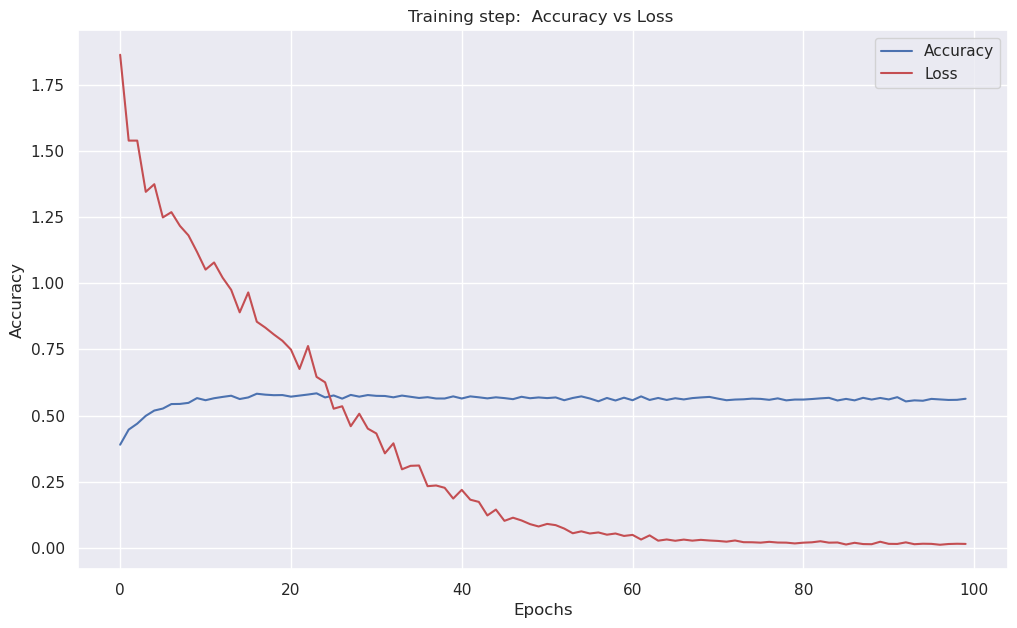

In [28]:
# Display the accuracy and loss over each training epoch
sns.set()
sns.set(rc={'figure.figsize':(12,7)}, font_scale=1)
plt.plot(accuracy_list,'b')
plt.plot(loss_list,'r')

plt.rcParams['figure.figsize'] = (7, 4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training step:  Accuracy vs Loss ")
plt.legend(['Accuracy','Loss'])
plt.show()

/tmp/ipykernel_29914/160710607.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot()


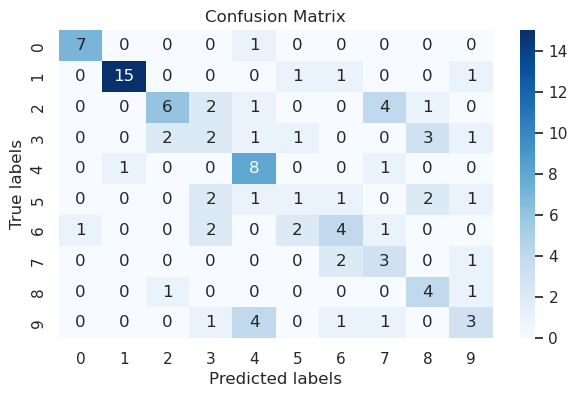

In [32]:
# Confusion matrix to see what labels are confused with each other
predictionlist=[]

for i in range(len(outputs)):
    p = int(torch.argmax(outputs[i]))
    predictionlist.append(p)
    
labels1=labels.argmax(-1).tolist()
labels1= [str(x) for x in labels1]

predictionlist= [str(x) for x in predictionlist]
labelsLIST = ['0','1', '2','3', '4','5', '6','7', '8','9']
cm = confusion_matrix(labels1, predictionlist, labels=labelsLIST)
ConfusionMatrixDisplay(cm).plot()

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels( ['0','1', '2','3', '4','5', '6','7', '8','9']); ax.yaxis.set_ticklabels(['0','1', '2','3', '4','5', '6','7', '8','9'])
plt.rcParams['figure.figsize'] = (8, 7)
plt.show()

As demonstrated, the 3D convolution takes a significant amount of time to train but can be reasonably accurate. It is not likely that this will be computationally feasible for the analyis of higher resolution tomographic data, but theoretically it could work to identify aligned and misaligned projection stacks. However, while a classifier may be feasible it is unlikely that a transformer would be feasible.